# Predicting COVID-19 Hospital Patient Length of Stay using Random Forest

### Synopsis & Background

* As the COVID-19 pandemic spikes, determining the needs for healthcare resources (beds, staff, equipment) has become a key priority for many countries. Projecting future demand requires estimates of how long patients with COVID-19 need different levels of hospital care.

* The patient length of stay is one of the critical parameters to observe and predict if an improvement to the efficiency of the healthcare management in a hospital is to be made. This parameter helps hospitals to identify patients of a high length of stay risk (patients who will stay longer) at the time of admission. 

* Once identified, prior knowledge of the length of stay of the patient being admitted can aid in logistics such as room, bed allocation, staff assignment, and PPE (Personal Protective Equipment) consumption planning. The problem is to manage the functioning of Hospitals professionally and optimally.

* Python is used as a tool of choice for the EDA and model development. In addition, the workstation, or the environment where the Random Forest models are fit & tuned is also important, since lack of processing resources could impediment fitting decently accurate models, especially when the random forest model needs to be hyper-tuned. 

* While some analysis of data is done locally on a workstation, to address this resource shortage on local workstations, the Azure ML node is utilized to fit & tune the models and perform most of the analysis. 

* The Azure ML node used, also known as a “Compute”, has a configuration of 56GB RAM, 6 cores CPU, 1 GPU, and 380GB disk space.

### Hypothesis of Study:
#### Null Hypothesis: 
The null hypothesis is that a random forest classification model cannot predict probabilities for target length of stay with 11 classes correctly i.e., the mean ROC-AUC score from Repeated Stratified K Fold Cross-Validation for random forest model on the validation data set is not more than 50%.

#### Alternate Hypothesis: 
An alternative hypothesis to the null hypothesis is that the random forest classification model predicts the probabilities for target length of stay classes and correctly distinguishes between the classes, i.e., the mean ROC-AUC score from Repeated Stratified K Fold Cross-Validation for random forest model on the validation data set is significantly greater than 50%. If the mean AUC score is more than 50%, then the Random Forest model offers a better intuition to manage the hospital resources optimally and it justifies implementing this complex solution.

## Project Outline:

1. Using Azure Student Subscription for ML development
2. Using DTALE & Seaborn Python libraries for EDA
3. Using Pandas, Numpy, Scikit-Learn, Imblearn and Matplotlib for deveoping predictive models for Dummy Classifier & Random Forest
3. Generating 2 Baseline models - Dummy & Random Forest with all default values
4. Hyperparameter tuning using RandomSearchCV and GridSearchCV combination
5. Generating RF models with Undersampled Majority class
6. Generating RF models with Oversampled Minority Class
7. Picking the best model with ROC AUC score using RepeatedStratifiedCV

In [1]:
import pandas as pd
import dtale

In [2]:
df = pd.read_csv("./host_train.csv")

In [3]:
df.head()

,case_id,Hospital,Hospital_type,Hospital_city,Hospital_region,Available_Extra_Rooms_in_Hospital,Department,Ward_Type,Ward_Facility,Bed_Grade,patientid,City_Code_Patient,Type of Admission,Illness_Severity,Patient_Visitors,Age,Admission_Deposit,Stay_Days
0,1,8,2,3,2,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,2,5,2,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,4,1,0,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,1,2,1,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,1,2,1,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


### Use D-Tale & Matplotlib Libraries to perform EDA

#### 1. On Original Data Frame

In [4]:
dtale.show(df)

2021-06-03 11:35:17,501 - INFO     - NumExpr defaulting to 8 threads.


<AxesSubplot:xlabel='Stay_Days,Illness_Severity'>

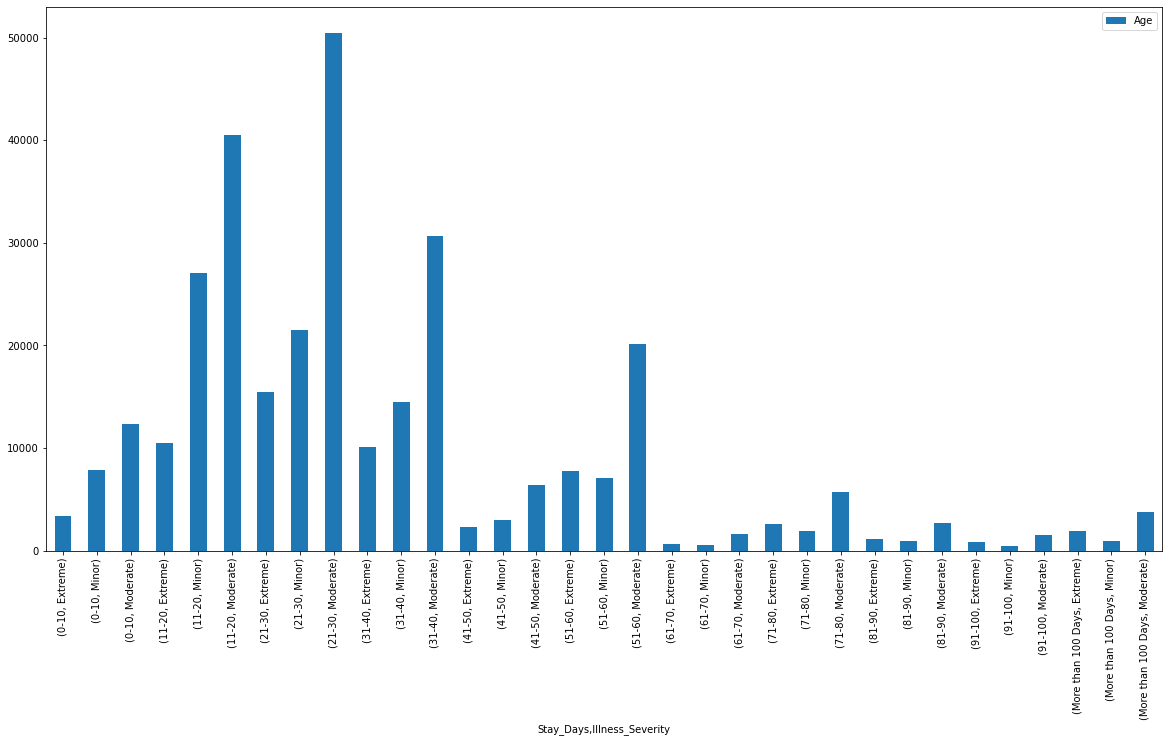

In [5]:
df[["Illness_Severity", "Stay_Days", "Age"]] \
.groupby(["Stay_Days", "Illness_Severity"]) \
.count().plot(kind="bar", figsize=(20,10))

#### Data Munging: Create new DataFrame after dropping duplicates

In [6]:
df1 = df.copy(deep=True)
df1.dropna(inplace=True)
df1.nunique()

case_id                              313793
Hospital                                 32
Hospital_type                             7
Hospital_city                            11
Hospital_region                           3
Available_Extra_Rooms_in_Hospital        18
Department                                5
Ward_Type                                 6
Ward_Facility                             6
Bed_Grade                                 4
patientid                             90344
City_Code_Patient                        37
Type of Admission                         3
Illness_Severity                          3
Patient_Visitors                         28
Age                                      10
Admission_Deposit                      7283
Stay_Days                                11
dtype: int64

#### 2. EDA on updated Dataframe without Duplicates

In [7]:
dtale.show(df1)

<AxesSubplot:xlabel='Stay_Days,Illness_Severity'>

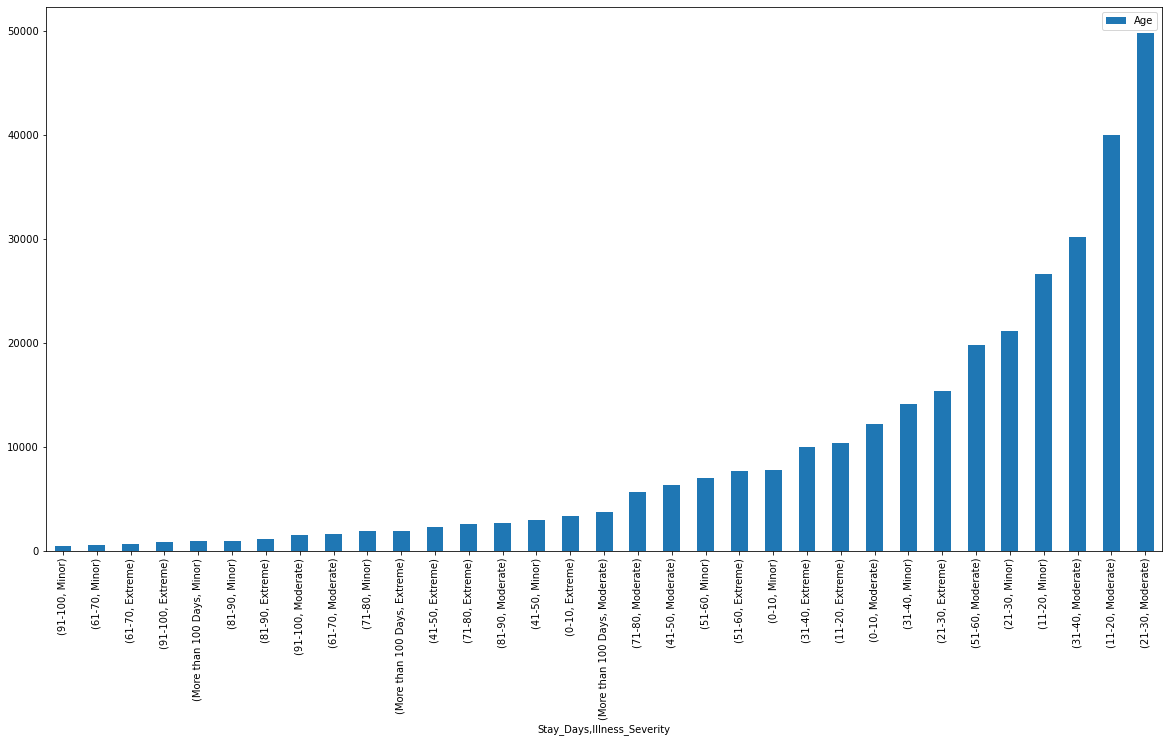

In [8]:
df1[["Illness_Severity", "Stay_Days", "Age"]].groupby(["Stay_Days", "Illness_Severity"]).count().sort_values(by=["Age"]).plot(kind="bar", figsize=(20,10))

In [10]:
df1.Patient_Visitors.value_counts().sort_values()

32         9
30         9
23        10
21        11
25        12
19        12
0         18
22        19
17        20
20        59
18        60
24        78
13       102
15       187
14       202
16       281
11       318
12       949
10      1168
1       1189
9       1331
7       2453
8       4775
5       9028
6      18510
3      58259
4      78044
2     136680
Name: Patient_Visitors, dtype: int64

<AxesSubplot:xlabel='Age,Stay_Days'>

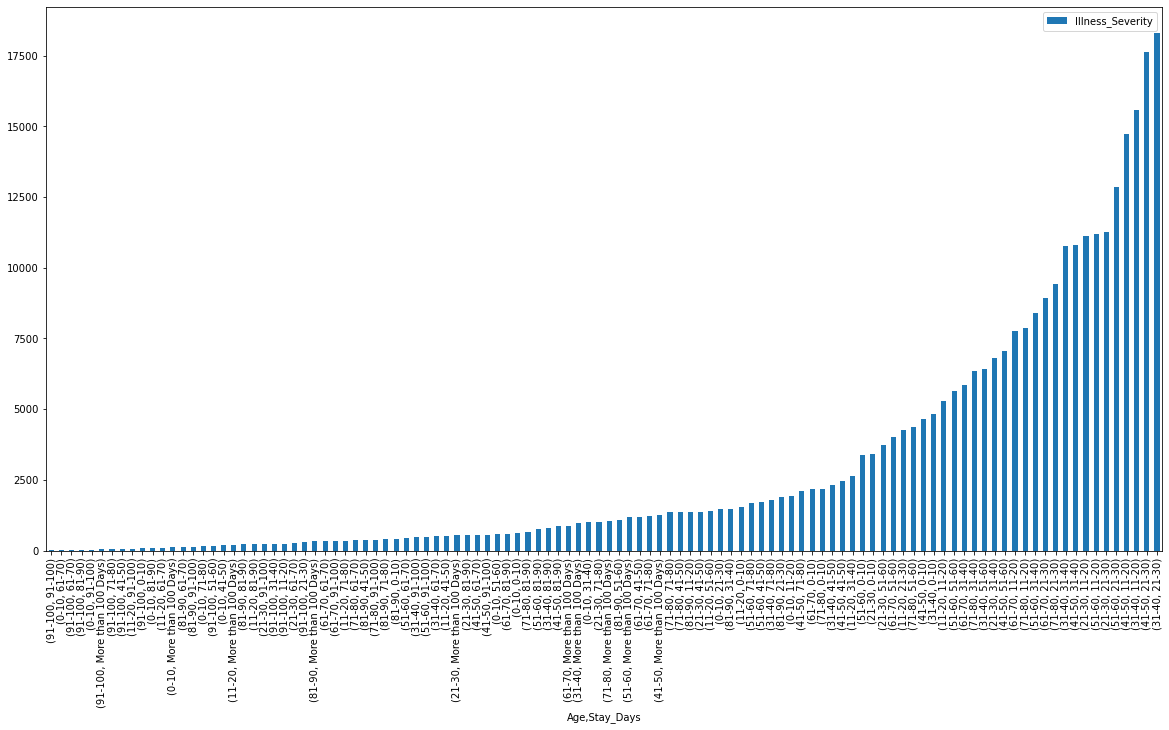

In [11]:
df1[["Illness_Severity", "Stay_Days", "Age"]]\
    .groupby(["Age", "Stay_Days"]).count()\
    .sort_values(by=["Illness_Severity"])\
    .plot(kind="bar", figsize=(20,10))

array([<AxesSubplot:ylabel='Stay_Days'>], dtype=object)

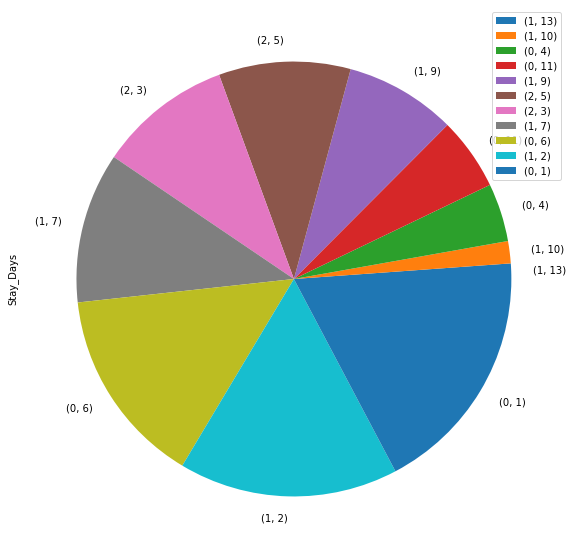

In [12]:
df1[["Hospital_region", "Hospital_city", "Stay_Days"]].groupby(["Hospital_region", "Hospital_city"]).count().sort_values(by=["Stay_Days"]).plot(kind="pie", figsize=(20,10), subplots=True)

array([<AxesSubplot:title={'center':'Stay_Days'}, xlabel='Hospital_region,Hospital_city'>],
      dtype=object)

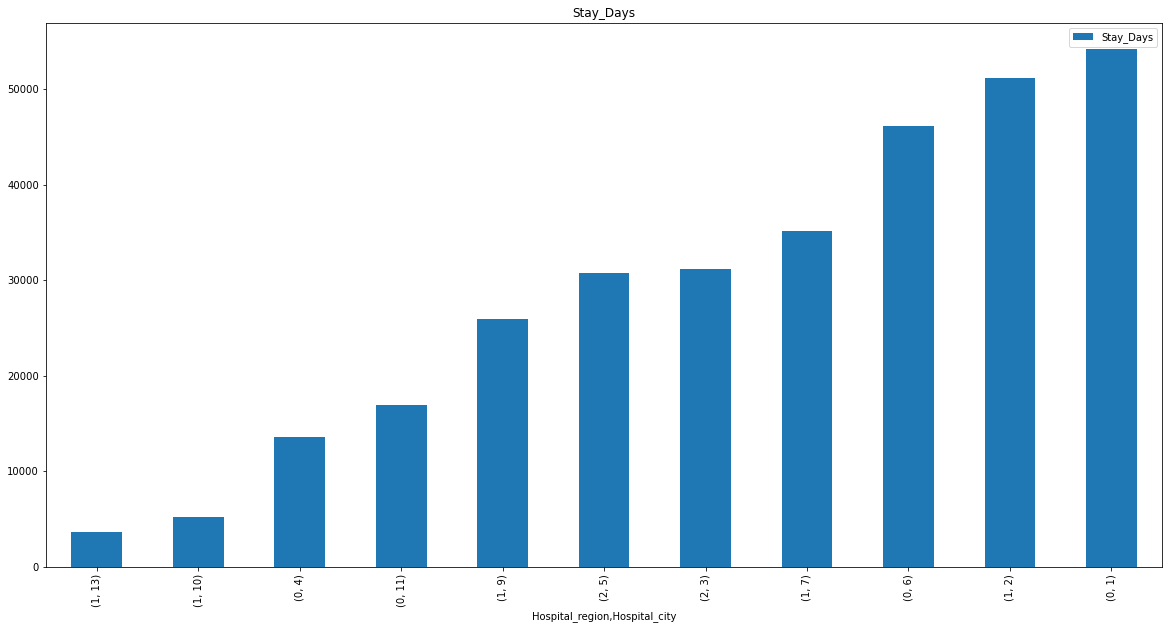

In [13]:
df1[["Hospital_region", "Hospital_city", "Stay_Days"]].groupby(["Hospital_region", "Hospital_city"]).count().sort_values(by=["Stay_Days"]).plot(kind="bar", figsize=(20,10), subplots=True)

In [15]:
df1 = df[["Hospital_region", "Stay_Days"]]
df1

,Hospital_region,Stay_Days
0,2,0-10
1,2,41-50
2,0,31-40
3,1,41-50
4,1,41-50
...,...,...
318433,0,11-20
318434,0,31-40
318435,0,11-20
318436,1,11-20


### Prepare dataframe to perform Test of Association between Region and Length of Stay using Tukey Post-Hoc Analysis

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["Stay_Days"] = le.fit_transform(df["Stay_Days"])
df1 = df[["Hospital_region", "Stay_Days"]]
df1

,Hospital_region,Stay_Days
0,2,0
1,2,4
2,0,3
3,1,4
4,1,4
...,...,...
318433,0,1
318434,0,3
318435,0,1
318436,1,1


In [18]:
from scikit_posthocs import posthoc_tukey
print(posthoc_tukey(df1, val_col="Stay_Days", group_col="Hospital_region"))

          2      0         1
2  1.000000  0.001  0.394298
0  0.001000  1.000  0.001000
1  0.394298  0.001  1.000000


In [19]:
p_values = posthoc_tukey(df1, val_col="Stay_Days", group_col="Hospital_region")
p_values

,2,0,1
2,1.000000,0.001,0.394298
0,0.001000,1.000,0.001000
1,0.394298,0.001,1.000000


### Conclusion: Regions 0 and 1, and 0 and 2 are significantly different from each other, whereas regions 1 and 2 are not significantly different in terms of patient length of stay

In [23]:
# Number of patients staying per LOS class by Hospital Region
df[["Hospital_region", "Stay_Days", "Age"]].groupby(["Hospital_region", "Stay_Days"]).count()

Age
Hospital_region Stay_Days       
0               0           8145
                1          33885
                2          38768
                3          22830
                4           4405
                5          14723
                6           1012
                7           4091
                8           1910
                9           1147
                10          2420
1               0          10447
                1          29786
                2          31595
                3          21314
                4           5036
                5          13023
                6           1184
                7           4069
                8           1940
                9           1068
                10          2966
2               0           5012
                1          14468
                2          17128
                3          11015
                4           2302
                5           7272
                6            548
                7           2094
                8            988
                9            550
                10          1297

# Additional EDA performed in AzureML Notebook - Please refer that notebook for more EDA results